## GCN - Recommender - Accuracy 86 % without optimisation

In [1]:
!pip install dgl-cu110 dglgo -f https://data.dgl.ai/wheels/repo.html &>/dev/null

In [2]:
import os
import pandas as pd
import numpy as np
import scipy.sparse as sp
import itertools
from tqdm import tqdm

import dgl
from dgl.data import DGLDataset
import dgl.nn as dglnn
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


In [3]:
content_path = "../input/coradata/cora/cora.content"
cite_path = "../input/coradata/cora/cora.cites"

with open(content_path, "r") as fp:
    contents = fp.readlines()
with open(cite_path, "r") as fp:
    cites = fp.readlines()

contents = np.array([np.array(l.strip().split("\t")) for l in contents])
paper_list, feat_list, label_list = np.split(contents, [1,-1], axis=1)
paper_list, label_list = np.squeeze(paper_list), np.squeeze(label_list)

paper_dict = dict([(key, val) for val, key in enumerate(paper_list)])

labels = list(set(label_list))
label_dict = dict([(key, val) for val, key in enumerate(labels)])

cites = [i.strip().split("\t") for i in cites]
cites = np.array([[paper_dict[i[0]], paper_dict[i[1]]] for i in cites], 
                 np.int64).T   
cites = np.concatenate((cites, cites[::-1, :]), axis=1) 
_, degree_list = np.unique(cites[0,:], return_counts=True)

In [4]:

node_num = len(paper_list)
feat_dim = feat_list.shape[1]
stat_dim = 32
num_class = len(labels)
T = 2
feat_Matrix = torch.Tensor(feat_list.astype(np.float32))
X_Node, X_Quote = np.split(cites, 2, axis=0)
X_Node, X_Quote = torch.from_numpy(np.squeeze(X_Node)), \
                 torch.from_numpy(np.squeeze(X_Quote))
label_list = np.array([label_dict[i] for i in label_list])
label_list = torch.from_numpy(label_list)

In [5]:
print('Node:', X_Node)
print('Quote:', X_Quote) 
print('label:', label_list) 
print('feat:', feat_Matrix) 

Node: tensor([ 163,  163,  163,  ..., 2258, 1887, 1686])
Quote: tensor([ 402,  659, 1696,  ..., 1887, 1902,  837])
label: tensor([2, 0, 4,  ..., 1, 6, 2])
feat: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [6]:
g = dgl.graph((X_Node, X_Quote), num_nodes=node_num)
g.ndata['feat'] = feat_Matrix
g.ndata['label'] = label_list

In [8]:
n_nodes = node_num
n_train = int(n_nodes * 0.6)
n_val = int(n_nodes * 0.2)
train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)
train_mask[:n_train] = True
val_mask[n_train:n_train + n_val] = True
test_mask[n_train + n_val:] = True
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

In [9]:
g = g.to('cuda')

In [10]:
print('Graph summary')
print(g)
print('Node features')
print(g.ndata)
print('Edge features')
print(g.edata)

Graph summary
Graph(num_nodes=2708, num_edges=10858,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})
Node features
{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'), 'label': tensor([2, 0, 4,  ..., 1, 6, 2], device='cuda:0'), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0'), 'val_mask': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')}
Edge features
{}


In [11]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [12]:
def train(g, model, epoch, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    
    
    for e in range(epoch):
        logits = model(g, features)

        pred = logits.argmax(1)
        
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 50 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))

In [13]:
model = GCN(g.ndata['feat'].shape[1], 16, len(g.ndata['label'].unique())).to('cuda')
train(g, model, epoch = 500, lr = 0.001)

In epoch 0, loss: 1.942, val acc: 0.159 (best 0.159), test acc: 0.204 (best 0.204)
In epoch 50, loss: 1.235, val acc: 0.562 (best 0.562), test acc: 0.554 (best 0.554)
In epoch 100, loss: 0.738, val acc: 0.819 (best 0.821), test acc: 0.761 (best 0.757)
In epoch 150, loss: 0.469, val acc: 0.841 (best 0.843), test acc: 0.810 (best 0.803)
In epoch 200, loss: 0.337, val acc: 0.848 (best 0.852), test acc: 0.812 (best 0.812)
In epoch 250, loss: 0.263, val acc: 0.854 (best 0.854), test acc: 0.810 (best 0.814)
In epoch 300, loss: 0.215, val acc: 0.852 (best 0.854), test acc: 0.803 (best 0.814)
In epoch 350, loss: 0.182, val acc: 0.847 (best 0.854), test acc: 0.801 (best 0.814)
In epoch 400, loss: 0.157, val acc: 0.845 (best 0.854), test acc: 0.805 (best 0.814)
In epoch 450, loss: 0.137, val acc: 0.837 (best 0.854), test acc: 0.807 (best 0.814)


In [14]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [15]:
lgb_df = pd.DataFrame(feat_list.astype(np.float32))
lgb_df['target'] = label_list
lgb_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [16]:
lgb_train_df = lgb_df[:n_train]
lgb_val_df = lgb_df[n_train:n_train + n_val]
lgb_test_df = lgb_df[n_train + n_val:]
print(lgb_train_df.shape)
print(lgb_val_df.shape)
print(lgb_test_df.shape)

(1624, 1434)
(541, 1434)
(543, 1434)


In [17]:
target_col = 'target'
train_y = lgb_train_df[target_col]
train_x = lgb_train_df.drop(target_col, axis=1)

val_y = lgb_val_df[target_col]
val_x = lgb_val_df.drop(target_col, axis=1)

test_y = lgb_test_df[target_col]
test_x = lgb_test_df.drop(target_col, axis=1)

trains = lgb.Dataset(train_x, train_y)
valids = lgb.Dataset(val_x, val_y)

In [18]:
params = {
    "objective": "multiclass",
    "boosting" : "gbdt",
    "num_class" : len(labels),
    "learning_rate": 0.01,       
    "metric": "multi_logloss", 
    "seed": 42,
}

In [19]:
model = lgb.train(params, trains, valid_sets=valids, num_boost_round=1000, early_stopping_rounds=100, verbose_eval=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 1624, number of used features: 392
[LightGBM] [Info] Start training from score -2.757919
[LightGBM] [Info] Start training from score -1.981001
[LightGBM] [Info] Start training from score -1.178039
[LightGBM] [Info] Start training from score -1.916184
[LightGBM] [Info] Start training from score -2.388701
[LightGBM] [Info] Start training from score -1.985476
[LightGBM] [Info] Start training from score -2.166901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.05589
[200]	valid_0's multi_logloss: 0.888613
[300]	valid_0's multi_logloss: 0.844305
[400]	valid_0's multi_logloss: 0.844727
Early stopping, best iteration is:
[329]	valid_0's multi_logloss: 0.83988


In [20]:
val_pred = model.predict(val_x).argmax(1)
print('validation data accuracy:', accuracy_score(val_y, val_pred))
test_pred = model.predict(test_x).argmax(1)
print('test data accuracy:', accuracy_score(test_y, test_pred))

validation data accuracy: 0.7264325323475046
test data accuracy: 0.7034990791896869


In [22]:
embedding = nn.Embedding(n_nodes, 128)  # nodes with embedding dim equal to 128
g.ndata['feat'] = embedding.weight.to('cuda')

In [23]:
model = GCN(g.ndata['feat'].shape[1], 16, len(g.ndata['label'].unique())).to('cuda')
train(g, model, epoch = 500, lr = 0.001)

In epoch 0, loss: 2.007, val acc: 0.118 (best 0.118), test acc: 0.116 (best 0.116)
In epoch 50, loss: 1.718, val acc: 0.264 (best 0.264), test acc: 0.265 (best 0.265)
In epoch 100, loss: 1.492, val acc: 0.303 (best 0.305), test acc: 0.309 (best 0.309)
In epoch 150, loss: 1.294, val acc: 0.335 (best 0.335), test acc: 0.320 (best 0.320)
In epoch 200, loss: 1.125, val acc: 0.359 (best 0.360), test acc: 0.357 (best 0.357)
In epoch 250, loss: 0.986, val acc: 0.377 (best 0.381), test acc: 0.376 (best 0.365)
In epoch 300, loss: 0.867, val acc: 0.386 (best 0.386), test acc: 0.378 (best 0.374)
In epoch 350, loss: 0.765, val acc: 0.397 (best 0.397), test acc: 0.383 (best 0.383)
In epoch 400, loss: 0.679, val acc: 0.412 (best 0.412), test acc: 0.398 (best 0.396)
In epoch 450, loss: 0.608, val acc: 0.421 (best 0.421), test acc: 0.401 (best 0.400)


In [24]:
u, v = g.edges()
u = u.detach().cpu().numpy()
v = v.detach().cpu().numpy()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

adj = sp.coo_matrix((np.ones(len(u)), (u, v)))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [25]:
train_g = dgl.remove_edges(g, eids[:test_size]).to('cuda')

In [26]:
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h 

In [27]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

In [28]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):

        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [29]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to('cuda')
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to('cuda')

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to('cuda')
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to('cuda')

In [30]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to('cuda')
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to('cuda')
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).detach().cpu().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).detach().cpu().numpy()
    return roc_auc_score(labels, scores)

In [31]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

all_logits = []
for e in range(100):
    h = model(train_g, train_g.ndata['feat'])
    
    pos_score = pred(train_pos_g, h)
    
    neg_score = pred(train_neg_g, h)
    
    loss = compute_loss(pos_score, neg_score)

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 25.651687622070312
In epoch 5, loss: 5.440237522125244
In epoch 10, loss: 2.454266309738159
In epoch 15, loss: 1.5988929271697998
In epoch 20, loss: 1.1452282667160034
In epoch 25, loss: 0.8541431427001953
In epoch 30, loss: 0.6978775262832642
In epoch 35, loss: 0.6105965375900269
In epoch 40, loss: 0.5539900064468384
In epoch 45, loss: 0.5147072076797485
In epoch 50, loss: 0.48575663566589355
In epoch 55, loss: 0.4630063772201538
In epoch 60, loss: 0.44508036971092224
In epoch 65, loss: 0.43055182695388794
In epoch 70, loss: 0.41794469952583313
In epoch 75, loss: 0.4065459072589874
In epoch 80, loss: 0.3963014483451843
In epoch 85, loss: 0.38692864775657654
In epoch 90, loss: 0.3781808912754059
In epoch 95, loss: 0.3700670301914215
AUC 0.7457869141413069


In [32]:
import dgl.data

dataset = dgl.data.GINDataset('PROTEINS', self_loop=True)

Extracting file to /root/.dgl/GINDataset


In [33]:
print('graph num:', len(dataset))
print('Number of graph categories:', dataset.gclasses)

graph num: 1113
Number of graph categories: 2


(Graph(num_nodes=42, num_edges=204,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))
target: tensor(0)


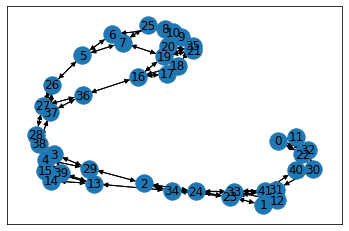

(Graph(num_nodes=45, num_edges=233,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), tensor(1))
target: tensor(1)


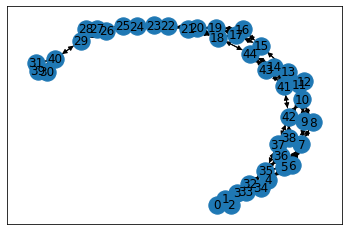

In [34]:

i = 0
print(dataset[i])
print('target:', dataset[i][1])

nx_graph = dgl.to_networkx(dataset[i][0])
nx.draw_networkx(nx_graph)
plt.show()

i = 800
print(dataset[i])
print('target:', dataset[i][1])

nx_graph = dgl.to_networkx(dataset[i][0])
nx.draw_networkx(nx_graph)
plt.show()

In [35]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False)

In [36]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=495, num_edges=2227,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), tensor([0, 0, 0, 0, 0])]


In [37]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)

Number of nodes for each graph element in the batch: tensor([328,  66,  38,  56,   7])
Number of edges for each graph element in the batch: tensor([1410,  316,  202,  262,   37])
The original graphs in the minibatch:
[Graph(num_nodes=328, num_edges=1410,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=66, num_edges=316,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=38, num_edges=202,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=56, num_edges=262,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=7, num_edges=37,
      ndata_schemes={'label': Scheme(shape=

In [38]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h') # 各nodeで得られた特徴量を平均。画像や言語で言うところのmean pooling。(Average the features obtained for each node)

In [39]:
model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(50)):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print('Test accuracy:', num_correct / num_tests)

100%|██████████| 50/50 [00:33<00:00,  1.50it/s]

Test accuracy: 0.26905829596412556


In [40]:
n_users = 1000
n_items = 500
n_follows = 3000
n_clicks = 5000
n_dislikes = 500
n_hetero_features = 10
n_user_classes = 5
n_max_clicks = 10

follow_src = np.random.randint(0, n_users, n_follows)
follow_dst = np.random.randint(0, n_users, n_follows)
click_src = np.random.randint(0, n_users, n_clicks)
click_dst = np.random.randint(0, n_items, n_clicks)
dislike_src = np.random.randint(0, n_users, n_dislikes)
dislike_dst = np.random.randint(0, n_items, n_dislikes)

hetero_graph = dgl.heterograph({
    ('user', 'follow', 'user'): (follow_src, follow_dst),
    ('user', 'followed-by', 'user'): (follow_dst, follow_src),
    ('user', 'click', 'item'): (click_src, click_dst),
    ('item', 'clicked-by', 'user'): (click_dst, click_src),
    ('user', 'dislike', 'item'): (dislike_src, dislike_dst),
    ('item', 'disliked-by', 'user'): (dislike_dst, dislike_src)})

hetero_graph.nodes['user'].data['feature'] = torch.randn(n_users, n_hetero_features)
hetero_graph.nodes['item'].data['feature'] = torch.randn(n_items, n_hetero_features)
hetero_graph.nodes['user'].data['label'] = torch.randint(0, n_user_classes, (n_users,))
hetero_graph.edges['click'].data['label'] = torch.randint(1, n_max_clicks, (n_clicks,)).float()
hetero_graph.nodes['user'].data['train_mask'] = torch.zeros(n_users, dtype=torch.bool).bernoulli(0.6)
hetero_graph.edges['click'].data['train_mask'] = torch.zeros(n_clicks, dtype=torch.bool).bernoulli(0.6)

In [41]:
hetero_graph

Graph(num_nodes={'item': 500, 'user': 1000},
      num_edges={('item', 'clicked-by', 'user'): 5000, ('item', 'disliked-by', 'user'): 500, ('user', 'click', 'item'): 5000, ('user', 'dislike', 'item'): 500, ('user', 'follow', 'user'): 3000, ('user', 'followed-by', 'user'): 3000},
      metagraph=[('item', 'user', 'clicked-by'), ('item', 'user', 'disliked-by'), ('user', 'item', 'click'), ('user', 'item', 'dislike'), ('user', 'user', 'follow'), ('user', 'user', 'followed-by')])

In [43]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):

        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [44]:
hetero_graph.etypes # edge type name

['clicked-by', 'disliked-by', 'click', 'dislike', 'follow', 'followed-by']

In [45]:
model = RGCN(n_hetero_features, 20, n_user_classes, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
labels = hetero_graph.nodes['user'].data['label']
train_mask = hetero_graph.nodes['user'].data['train_mask']

In [46]:
node_features = {'user': user_feats, 'item': item_feats}
h_dict = model(hetero_graph, {'user': user_feats, 'item': item_feats}) # 出力はuser/itemノードそれぞれ畳み込まれて出てくる。The output is collapsed for each user/item node.
h_user = h_dict['user']
h_item = h_dict['item']

In [47]:
h_user 

tensor([[-0.4162,  0.4354,  0.5300,  0.8226,  1.9984],
        [ 0.3528, -0.1653,  0.4434,  0.3868,  1.2398],
        [ 0.9330,  1.2088, -0.1672, -0.1282,  1.1965],
        ...,
        [-1.5482,  1.2972, -1.8416, -0.3047,  3.7202],
        [-0.0867,  0.8367,  0.3296,  0.3826,  2.4555],
        [ 0.1021,  0.1535, -0.6431,  0.5670,  1.1972]], grad_fn=<SumBackward1>)

In [48]:
opt = torch.optim.Adam(model.parameters())

for epoch in range(20):
    model.train()
    logits = model(hetero_graph, node_features)['user']

    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())


1.928112268447876
1.9066755771636963
1.8865209817886353
1.8676482439041138
1.8500213623046875
1.833621859550476
1.8183996677398682
1.804280161857605
1.7912168502807617
1.7791231870651245
1.7679312229156494
1.7575643062591553
1.7479500770568848
1.7390235662460327
1.7307238578796387
1.722990870475769
1.7157812118530273
1.7090342044830322
1.7027019262313843
1.6967371702194214
